# Clusterings results analysis - for Romina's congress

We trained a FCM model with k=10 on 13 samples agreed and coordinated with Talia. After training, we load the model, and make prediction on a new sample (emc_0119). Then we show a single slide

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.io
import pandas as pd

## Load validation matrix, rescale and make cluster predictions

In [ ]:
# load trained model
with open("/home/labs/bioservices/eligol/01_projects/06_pregnancy_MRI/data/13_samples_4channels_labels/FCM_10_means/FCM_K10_13_samples_model.pkl", "rb") as f:
    fcm10_model = pickle.load(f)

(360, 320, 260, 4)
max pixel: 3.0
min pixel: 0.0
bit depth: 22.347691108157253


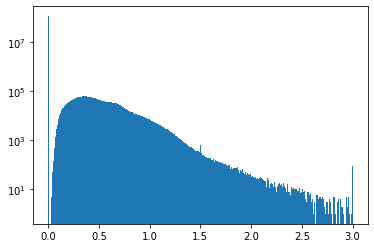

In [13]:
# load new sample to test on
val_mat = scipy.io.loadmat("/home/labs/neeman/Collaboration/Placenta_MRI_2021/data/raw_data_dropbox/4channels/emc_0019_cass.mat")
val_mat = val_mat['map_mat']    

# some info about the validation matrix
print(val_mat.shape)
print("max pixel:", val_mat.max())
print("min pixel:", val_mat.min())
print("bit depth:", np.log2(len(np.unique(val_mat))))

plt.hist(val_mat.ravel(), bins=512, log=True)
plt.show()

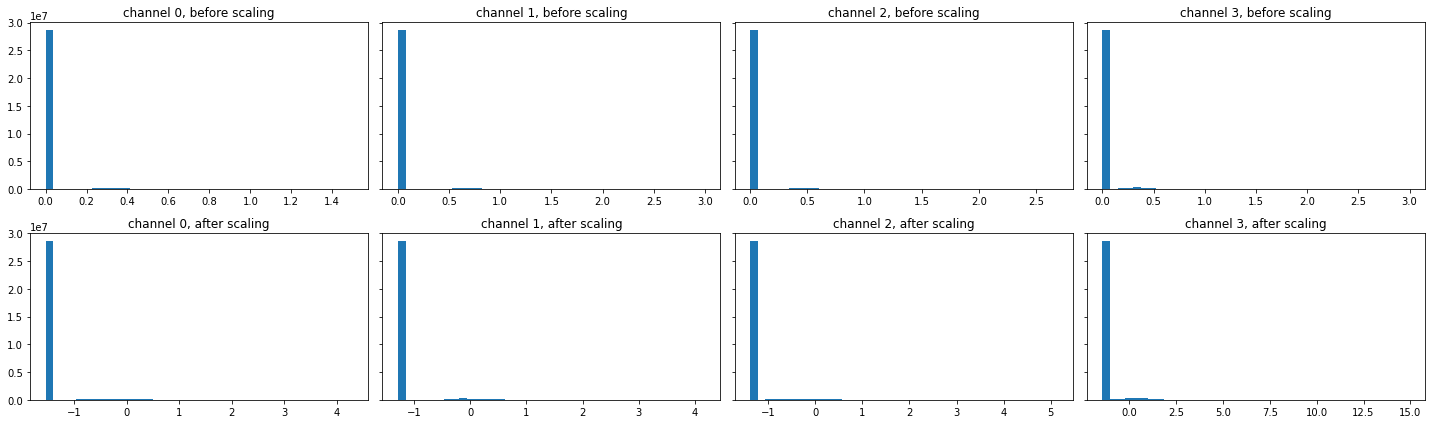

In [24]:
# standard scale the val sample
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(2, val_mat.shape[-1], figsize=(20,6), sharey=True)

for i in range(val_mat.shape[-1]):
    ax[0][i].hist(val_mat[:,:,:,i].ravel(), bins=40)
    ax[0][i].set_title("channel {}, before scaling".format(i))

# load sclaer tat was fitted on training set
with open("/home/labs/bioservices/eligol/01_projects/06_pregnancy_MRI/code/13_samlple_4ch_std_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
# transform val data
val_mat_scaled = scaler.transform(val_mat.reshape(-1, val_mat.shape[-1])).reshape(val_mat.shape)

for i in range(val_mat_scaled.shape[-1]):
    ax[1][i].hist(val_mat_scaled[:,:,:,i].ravel(), bins=40)
    ax[1][i].set_title("channel {}, after scaling".format(i))

plt.tight_layout()
plt.show()

In [25]:
scaler.mean_

array([0.3953697 , 0.70912104, 0.57103245, 0.26343148])

In [28]:
# reshape the validation array to a vector
print("shpae before:", val_mat_scaled.shape)
vec_to_cluster = np.reshape(val_mat_scaled, newshape=(val_mat_scaled.shape[0] * val_mat_scaled.shape[1] * val_mat_scaled.shape[2] ,val_mat_scaled.shape[3]))
print("shpae after:", vec_to_cluster.shape)

val_mat_pred = fcm10_model.predict(vec_to_cluster)
# val_mat_pred = np.random.randint(0, 10,(vec_to_cluster.shape[0]))
                
# return to original shape
val_mat_pred = np.reshape(val_mat_pred.astype('int8'), newshape=(val_mat_scaled.shape[0], val_mat_scaled.shape[1], val_mat_scaled.shape[2]))
val_mat_pred.shape

shpae before: (360, 320, 260, 4)
shpae after: (29952000, 4)


(360, 320, 260)

### plots of predicted clusters validation sample

clusters observed: [0 1 2 3 4 5 6 7 8 9]


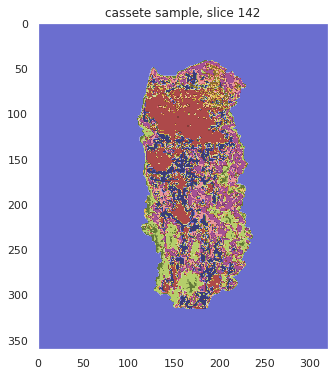

In [67]:
plt.imshow(val_mat_pred[:, :, 142], cmap='tab20b')
plt.title("cassete sample, slice 142")
print("clusters observed:", np.unique(val_mat_pred[:, :, 142]))
plt.grid(None) 
plt.savefig("cassete_clusters_slice_142.png",dpi=400)
plt.show()

## barplot for control samples

In [32]:
# load the masked matrix of the samples
all_snames = ['emc_0117', 'emc_0201', 'mmc_0122', 'hmo_0252', 'mmc_0178', 'hymc_0085', 'mmc_0255', 'mmc_0084', 'mmc_0129', 'mmc_0123', 'mmc_0086', 'mmc_0228', 'mmc_0128']
clusters_path = '/home/labs/bioservices/eligol/01_projects/06_pregnancy_MRI/data/13_samples_4channels_labels/FCM_10_means/labels_mask_4ch.npy'
clusters_mat = np.load(clusters_path)

clusters_mat_ctrl = clusters_mat[:9]
clusters_mat_GD = clusters_mat[9:]

In [42]:
# create a data frame with the data
df_all_samples = pd.DataFrame()
for i in range(clusters_mat.shape[0]):
    labels, label_counts = np.unique(clusters_mat[i,:,:,:], return_counts=True)
    df_temp = pd.DataFrame(np.array([labels, label_counts]).T, columns = ['label', 'pixel_counts'])
    df_temp['sname'] = all_snames[i]
    df_temp['class'] = 'control' if i < 9 else 'GD'
    df_all_samples = pd.concat([df_all_samples, df_temp], ignore_index=True)
df_all_samples

label  pixel_counts     sname    class
0        0        857575  emc_0117  control
1        1       1050181  emc_0117  control
2        2        247870  emc_0117  control
3        3        378107  emc_0117  control
4        4        504167  emc_0117  control
..     ...           ...       ...      ...
125      5        438344  mmc_0128       GD
126      6        442538  mmc_0128       GD
127      7        417555  mmc_0128       GD
128      8        720835  mmc_0128       GD
129      9        105527  mmc_0128       GD

[130 rows x 4 columns]

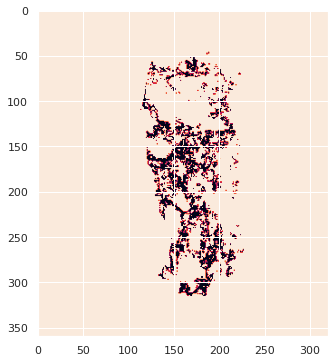

In [71]:
t = val_mat_pred[:, :, 142]
t[t > 0] = 1
plt.imshow(t*255)

(array([[  0.,   0.,   0., ...,   0.,   0., 360.],
        [  0.,   0.,   0., ...,   0.,   0., 360.],
        [  0.,   0.,   0., ...,   0.,   0., 360.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0., 360.],
        [  0.,   0.,   0., ...,   0.,   0., 360.],
        [  0.,   0.,   0., ...,   0.,   0., 360.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 320 BarContainer objects>)

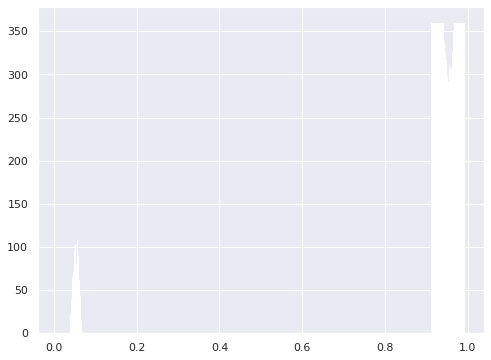

In [72]:
plt.hist(t)

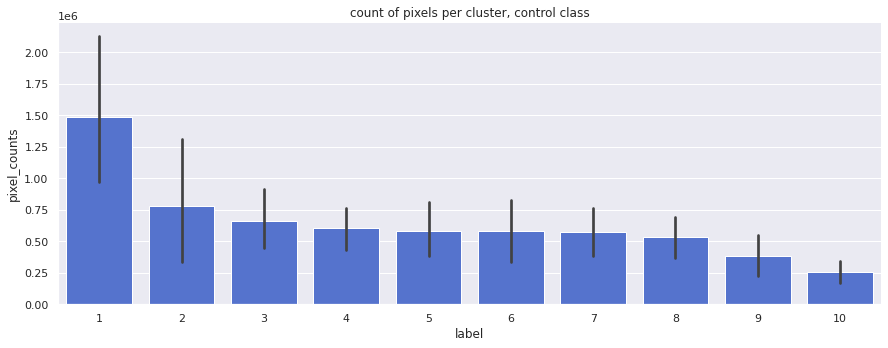

In [63]:
s = sns.catplot(x='label', y='pixel_counts', data=df_all_samples[df_all_samples['class'] == 'control']
                , order=[1, 6,0,8,7,2,3,4,5,9],kind="bar", color='royalblue', aspect=2.5)
s.set_xticklabels([str(k + 1) for k in labels])
plt.title("count of pixels per cluster, control class")
plt.tight_layout()
plt.savefig('pixel_counts_per_cluster_control.png')
plt.show()

In [74]:
!pip install statannot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/apps/RH7U2/gnu/miniconda/2020.02/python/3.7/bin/python -m pip install --upgrade pip' command.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04



TypeError: __init__() missing 1 required positional argument: 'seed'

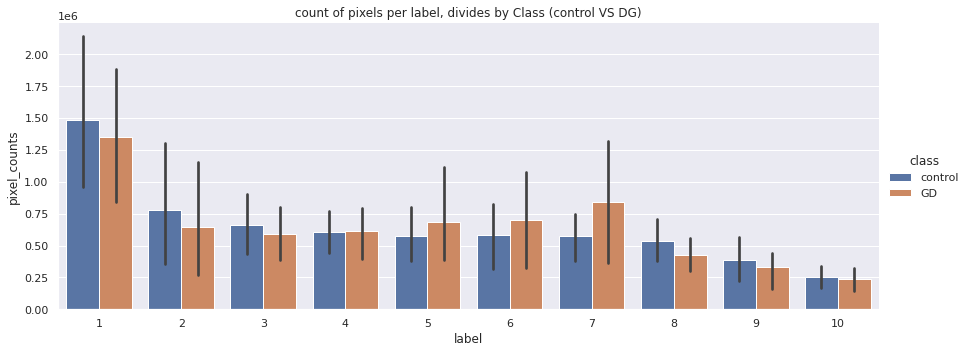

In [82]:
from statannot import add_stat_annotation
s = sns.catplot(x='label', y='pixel_counts', data=df_all_samples, hue="class", kind="bar", order=[1,6,0,8,7,2,3,4,5,9], aspect=2.5)
s.set_xticklabels([str(k+1) for k in labels])
plt.title("count of pixels per label, divides by Class (control VS DG)")


# def annotate(data, **kws):
#     n = len(data)
#     ax = plt.gca()
#     ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)
# s.map_dataframe(annotate)

#add statistic  notation
add_stat_annotation(s.ax,plot='barplot', data=df_all_samples, x='label', y='pixel_counts',hue="class", order=[1,6,0,8,7,2,3,4,5,9],
                    test='Mann-Whitney', text_format='star', verbose=2)

plt.tight_layout()
plt.savefig('pixel_counts_per_label_ctrl_DG.png')
plt.show()